In [64]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated, partition
# using CuArrays

In [65]:
using PyPlot

In [66]:
imgs = MNIST.images()
labels = onehotbatch(MNIST.labels(), 0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false   true  false  false  false  …  false  false  false  false  false
 false  false  false   true  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false   true  false  false     false  false  false  false  false
  true  false  false  false  false  …  false  false   true  false  false
 false  false  false  false  false     false  false  false   true  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false      true  false  false  false   true
 false  false  false  false   true     false  false  false  false  false

In [67]:
imgs[3]

#### Make partitions of the data (batches)

In [68]:
# Partition into batches of size 1,000
train = [(cat(4, float.(imgs[i])...), labels[:,i])
         for i in partition(1:60_000, 250)]

train = gpu.(train);

In [69]:
length(train)

240

In [70]:
typeof(imgs[3])

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [71]:
size(train)

(240,)

In [72]:
size(train[1][1])

(28, 28, 1, 250)

In [73]:
size(train[1][2])

(10, 250)

In [74]:

# Prepare test set (first 1,000 images)
tX = cat(4, float.(MNIST.images(:test)[1:1000])...) |> gpu
tY = onehotbatch(MNIST.labels(:test)[1:1000], 0:9) |> gpu

m = Chain(
  Conv((2,2), 1=>32, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 32=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10), softmax) |> gpu


Chain(Conv((2, 2), 1=>32, NNlib.relu), #25, Conv((2, 2), 32=>8, NNlib.relu), #26, #27, Dense(288, 10), NNlib.softmax)

In [75]:
size(tX), size(tY)

((28, 28, 1, 1000), (10, 1000))

#### Defining a loss function

In [76]:
loss(x, y) = crossentropy(m(x), y)

loss (generic function with 1 method)

#### Defining an evaluation metric

In [77]:
accuracy(x, y) = mean(argmax(m(x)) .== argmax(y))

accuracy (generic function with 1 method)

In [78]:
evalcb = throttle(() -> @show(accuracy(tX, tY)), 10)

(::throttled) (generic function with 1 method)

#### Define a an optimization procedure

In [79]:
length(train)

240

In [80]:
opt = ADAM(params(m))

(::#89) (generic function with 1 method)

In [81]:
Flux.train!(loss, train, opt, cb = evalcb)

accuracy(tX, tY) = 0.112
accuracy(tX, tY) = 0.11
accuracy(tX, tY) = 0.191
accuracy(tX, tY) = 0.479
accuracy(tX, tY) = 0.542
accuracy(tX, tY) = 0.674
accuracy(tX, tY) = 0.726
accuracy(tX, tY) = 0.762
accuracy(tX, tY) = 0.806
accuracy(tX, tY) = 0.824
accuracy(tX, tY) = 0.833
accuracy(tX, tY) = 0.846
accuracy(tX, tY) = 0.853
accuracy(tX, tY) = 0.853
accuracy(tX, tY) = 0.862
accuracy(tX, tY) = 0.858
accuracy(tX, tY) = 0.866
accuracy(tX, tY) = 0.869
accuracy(tX, tY) = 0.873


In [82]:
length(train)

240

### Make a prediction for a sample

We can use the indmax function to make a prediction 

In [24]:
m(x)

LoadError: [91mUndefVarError: x not defined[39m

In [25]:
predict(x) = indmax(m(x))-1

predict (generic function with 1 method)

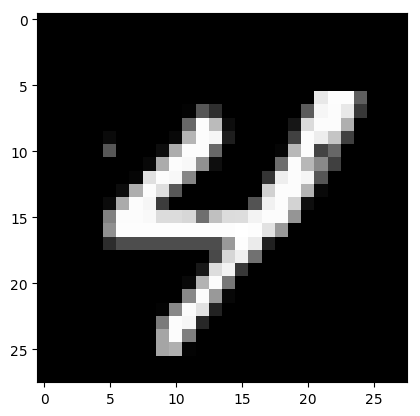

In [26]:
n=90
x = train[1][1][:,:,:,n:n]
PyPlot.imshow(reshape(x,28,28); cmap="gray")
print("Prediction:", predict(x))

Prediction:4

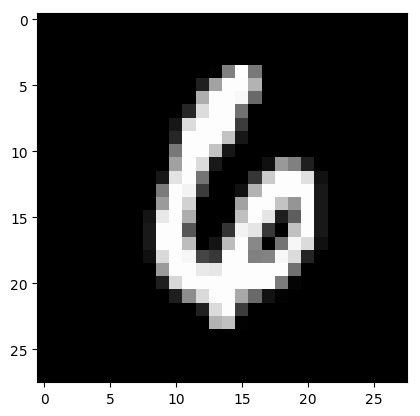

In [27]:
n=40
x = train[1][1][:,:,:,n:n]
PyPlot.imshow(reshape(x,28,28); cmap="gray")
print("Prediction:", predict(x))

Make a prediction for a set of 25 samples

In [28]:
probs = m(train[1][1][:,:,:,1:25])

Tracked 10×25 Array{Float64,2}:
 0.00111994   0.99952      7.52281e-5   …  7.47448e-5   0.0675375  
 0.000827037  7.19762e-11  2.59034e-6      0.958103     0.34483    
 0.00104798   7.39852e-6   0.000403035     0.0119284    0.246063   
 0.252286     2.8987e-5    0.0170481       0.00179601   0.0180441  
 1.42748e-5   1.93911e-7   0.95346         0.00173627   0.000152188
 0.743487     0.000377442  0.000653772  …  0.000366538  0.170238   
 0.000467639  4.37982e-5   0.00011911      7.18648e-5   0.142191   
 0.00029234   1.23204e-6   0.00902621      0.000913204  0.000469663
 0.00033849   1.94409e-5   0.00275342      0.024528     0.0075825  
 0.000118703  1.97191e-6   0.0164582       0.000482158  0.00289356 

In [29]:
indmax(probs[:,3])

5

In [30]:
predict_from_prob(prob::AbstractVector) = indmax(prob)-1

predict_from_prob (generic function with 1 method)

In [31]:
n_cols = size(probs)

(10, 25)

In [32]:
function predict_from_prob(probs::AbstractMatrix)
    n_cols = size(probs)[2]
    predictions = []
    for col in 1:n_cols
        push!(predictions, predict_from_prob(view(probs,:,col)))
    end
    return predictions
end

predict_from_prob (generic function with 2 methods)

In [33]:
predict_from_prob(probs)

25-element Array{Any,1}:
 5
 0
 4
 1
 9
 2
 1
 3
 1
 4
 3
 1
 3
 6
 1
 7
 2
 8
 6
 9
 4
 0
 9
 1
 1

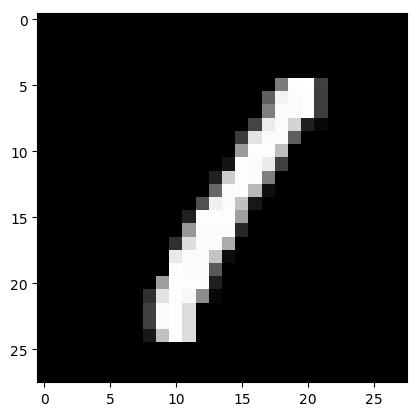

Prediction:1

In [34]:
n=4
x = train[1][1][:,:,:,n:n]
PyPlot.imshow(reshape(x,28,28); cmap="gray")
print("Prediction:", predict(x))

## Saving the model

Models are just normal Julia structs, so it's fine to use any Julia storage format for this purpose. BSON.jl is particularly well supported and most likely to be forwards compatible (that is, models saved now will load in future versions of Flux).

#### Note
If a saved model's weights are stored on the GPU, the model will not load later on if there is no GPU support available. It's best to move your model to the CPU with cpu(model) before saving it.



In [35]:
using BSON: @save
@save "mymodel.bson" m

In [36]:
using BSON: @load

In [42]:
@load "mymodel.bson" m

In [44]:
m

Chain(Conv((2, 2), 1=>32, NNlib.relu), BSON.__deserialized_types__.#3, Conv((2, 2), 32=>8, NNlib.relu), BSON.__deserialized_types__.#4, BSON.__deserialized_types__.#5, Dense(288, 10), NNlib.softmax)

### Save model weights

- **`Flux.loadparams!`**

In [47]:
weights = Tracker.data.(params(m));

In [49]:
@save "m_weights.bson" weights

In [54]:
m2 = Chain(
  Conv((2,2), 1=>32, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 32=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10), softmax)


Chain(Conv((2, 2), 1=>32, NNlib.relu), #17, Conv((2, 2), 32=>8, NNlib.relu), #18, #19, Dense(288, 10), NNlib.softmax)

In [56]:
@load "m_weights.bson" weights

In [58]:
Flux.loadparams!(m2, weights)

In [59]:
m2

Chain(Conv((2, 2), 1=>32, NNlib.relu), #17, Conv((2, 2), 32=>8, NNlib.relu), #18, #19, Dense(288, 10), NNlib.softmax)

## Checkpoints

## Train more

In [62]:
@save "./saved_models/model-$(now()).bson" m

In [83]:
for i in 1:10
    Flux.train!(loss, train, opt, cb = evalcb)
    #@save "./saved_models/model-$(now()).bson" m
end

accuracy(tX, tY) = 0.865
accuracy(tX, tY) = 0.874


LoadError: [91mInterruptException:[39m